#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [1]:
%reset -f
import numpy as np
import pandas as pd
import math
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [2]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [3]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


In [ ]:
len(feature_names)

This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [ ]:
car_data[4:7]

In [4]:
LABEL = 'price'

numeric_feature_names = ['symboling','normalized-losses','wheel-base','engine-size','bore','stroke', 'length', 'width', 'height','weight','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg']
categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))
print(len(numeric_feature_names))
# The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

15


In [5]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [6]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
86,1,125,96.30,172.40,65.40,51.60,2405,122,88,5000,25,32,3.35,3.46,8.50
76,2,161,93.70,157.30,64.40,50.80,1918,92,68,5500,37,41,2.97,3.23,9.40
34,1,101,93.70,150.00,64.00,52.60,1956,92,76,6000,30,34,2.91,3.41,9.20
103,0,108,100.40,184.60,66.50,55.10,3060,181,152,5200,19,25,3.43,3.27,9.00
8,1,158,105.80,192.70,71.40,55.90,3086,131,140,5500,17,20,3.13,3.40,8.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,128,94.50,165.30,63.80,54.50,1918,97,69,5200,31,37,3.15,3.29,9.40
105,3,194,91.30,170.70,67.90,49.70,3139,181,200,5200,17,23,3.43,3.27,7.80
89,1,128,94.50,165.30,63.80,54.50,1889,97,69,5200,31,37,3.15,3.29,9.40
193,0,?,100.40,183.10,66.90,55.10,2563,109,88,5500,25,31,3.19,3.40,9.00


In [7]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,body-style,num-doors,fuel-system,drive-wheels,fuel-type,make,engine-location,engine-type,aspiration,num-cylinders
86,sedan,four,2bbl,fwd,gas,mitsubishi,front,ohc,std,four
76,hatchback,two,2bbl,fwd,gas,mitsubishi,front,ohc,std,four
34,hatchback,two,1bbl,fwd,gas,honda,front,ohc,std,four
103,sedan,four,mpfi,fwd,gas,nissan,front,ohcv,std,six
8,sedan,four,mpfi,fwd,gas,audi,front,ohc,turbo,five
...,...,...,...,...,...,...,...,...,...,...
91,sedan,two,2bbl,fwd,gas,nissan,front,ohc,std,four
105,hatchback,two,mpfi,rwd,gas,nissan,front,ohcv,turbo,six
89,sedan,two,2bbl,fwd,gas,nissan,front,ohc,std,four
193,wagon,four,mpfi,fwd,gas,volkswagen,front,ohc,std,four


In [8]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [9]:
# This code "works", but because of bad hyperparameter choices it gets NaN loss
# during training. Try fixing this.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...
INFO:tensorflow:Saving checkpoints for 1000 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpdgn4ymp_/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...
INFO:tensorflow:loss = 216372200.0, step = 1001
INFO:tensorflow:global_step/sec: 612.771
INFO:tensorflow:loss = 257920800.0, step = 1101 (0.165 sec)
INFO:tensorflow:global_step/sec: 600.521
INFO:tensorflow:loss = 278882620.0, step = 1201 (0.167 sec)
INFO:tensorflow:global_step/sec: 585.961
INFO:tensorflow:loss = 421352060.0, step = 1301 (0.174 sec)
INFO:tensorflow:global_step/sec: 649.834
INFO:tensorflow:loss = 542826240.0, step = 1401 (0.151 sec)
INFO:tensorflow:global_step/sec: 558.82
INFO:tensorflow:loss = 294242560.0, step = 1501 (0.177 sec)
INFO:tensorflow:global_step/sec: 601.221
INFO:tensorflow:loss = 200007280.0, step = 1601 (0.171 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpdgn4ymp_/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4000...
INFO:tensorflow:Saving checkpoints for 4000 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpdgn4ymp_/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4000...
INFO:tensorflow:loss = 111487816.0, step = 4001
INFO:tensorflow:global_step/sec: 648.93
INFO:tensorflow:loss = 207377920.0, step = 4101 (0.158 sec)
INFO:tensorflow:global_step/sec: 648.844
INFO:tensorflow:loss = 215697460.0, step = 4201 (0.156 sec)
INFO:tensorflow:global_step/sec: 623.881
INFO:tensorflow:loss = 446916700.0, step = 4301 (0.159 sec)
INFO:tensorflow:g

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.17586s
INFO:tensorflow:Finished evaluation at 2020-08-30-13:36:55
INFO:tensorflow:Saving dict for global step 7000: average_loss = 23814748.0, global_step = 7000, label/mean = 12949.43, loss = 375540260.0, prediction/mean = 12887.202
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7000: /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpdgn4ymp_/model.ckpt-7000
scores {'average_loss': 23814748.0, 'label/mean': 12949.43, 'loss': 375540260.0, 'prediction/mean': 12887.202, 'global_step': 7000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpdgn4ymp_/model.ckpt-7000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorf

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-30T13:37:02Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpdgn4ymp_/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.19125s
INFO:tensorflow:Finished evaluation at 2020-08-30-13:37:03
INFO:tensorflow:Saving dict for global step 10000: average_loss = 23052622.0, global_step = 10000, label/mean = 12949.43, loss = 363522100.0, prediction/mean = 13146.191
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpdgn4ymp_/model.ckpt-10000
scores {'average_loss': 23052622.0, 'label/mean': 12949.43, 'loss': 363522100.0, 'prediction/mean': 13146.191, 'global_step': 10000}


### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpdgn4ymp_/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


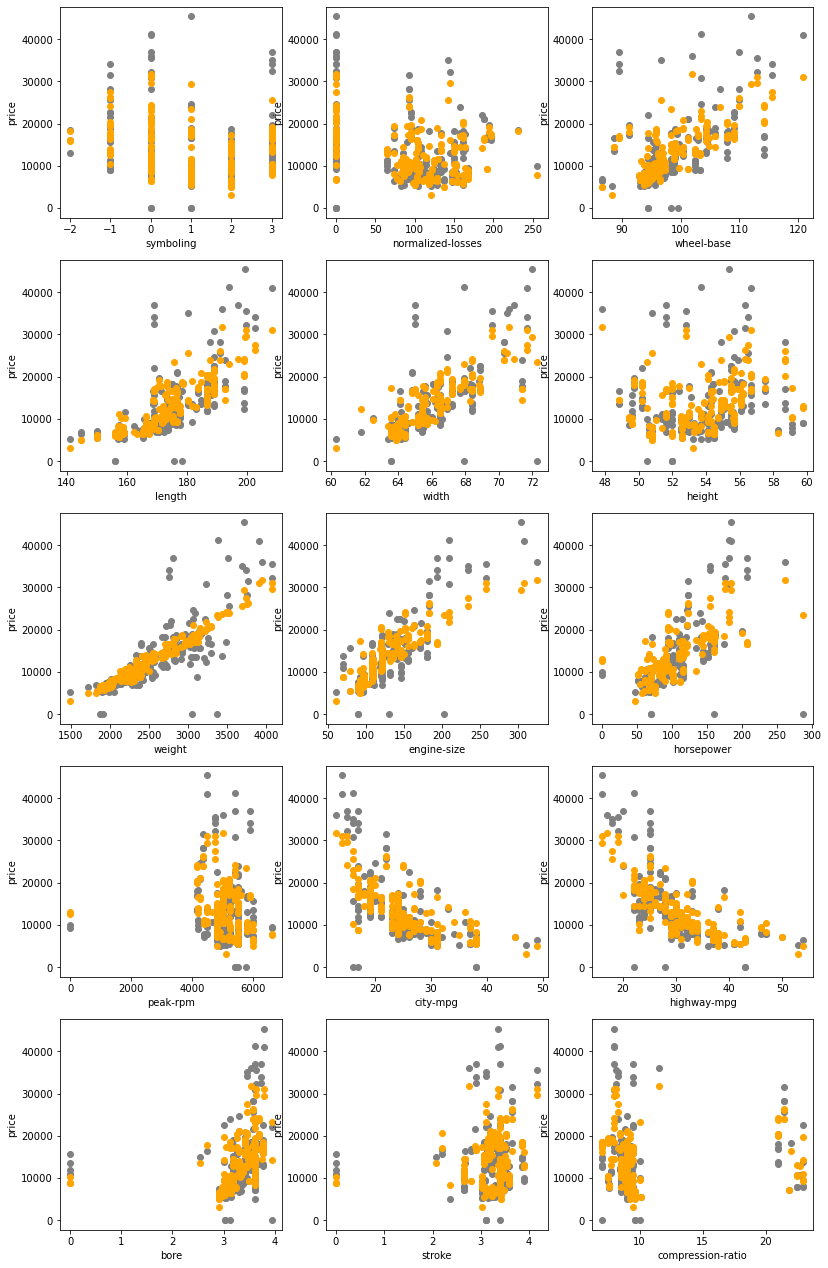

In [10]:
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.
  
  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]
  
  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)
  
  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

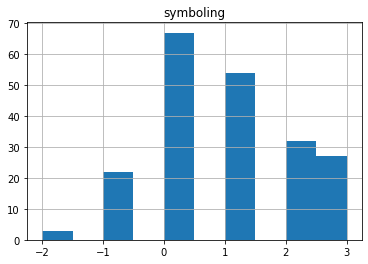

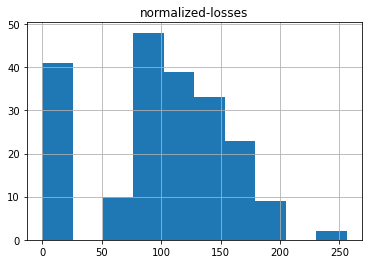

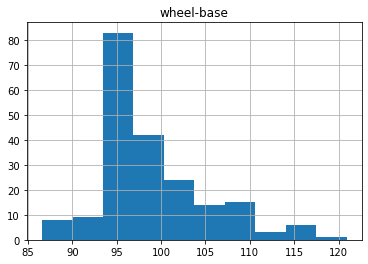

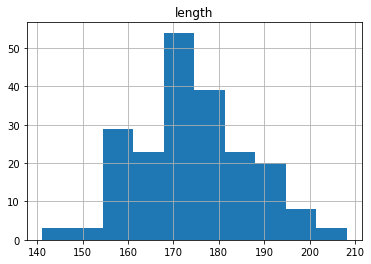

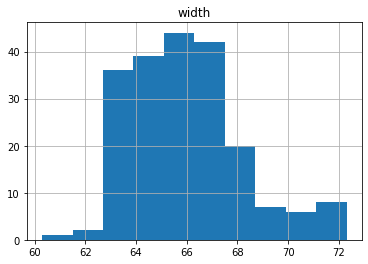

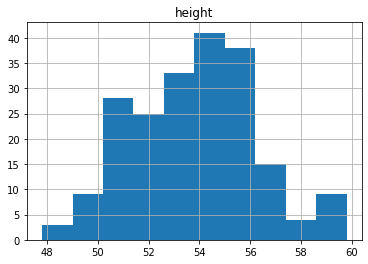

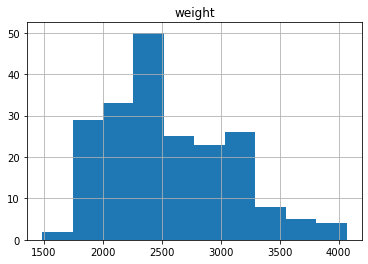

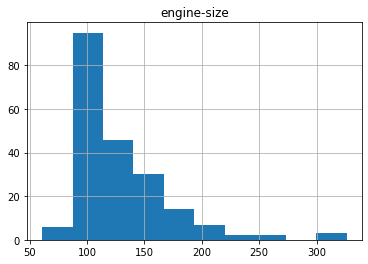

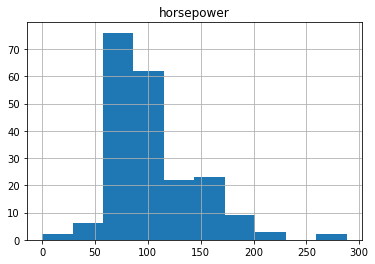

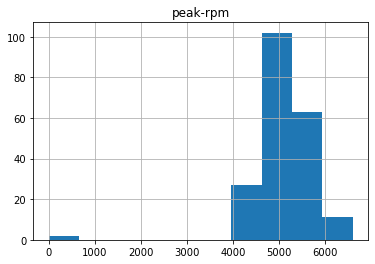

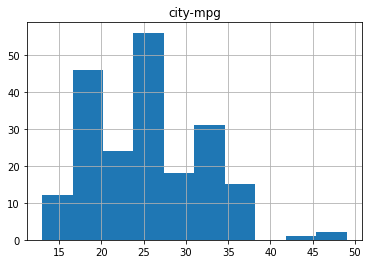

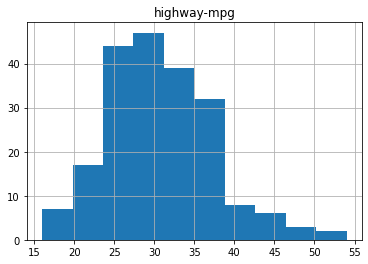

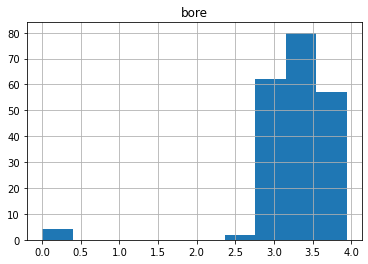

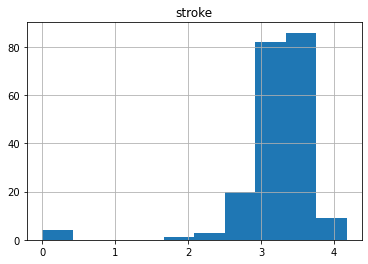

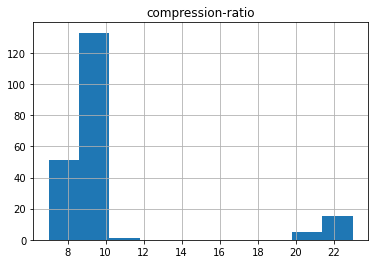

In [11]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

In [ ]:
## Your code goes here
# x_df.head()
# y_series.head()
x_df.describe()

In [12]:
print(numeric_feature_names)

model_feature_cols = [
    tf.feature_column.numeric_column(feature_name, normalizer_fn=lambda val: val - x_df.mean()[feature_name] / x_df.std()[feature_name]) 
    for feature_name in numeric_feature_names
]

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']


In [14]:
# print('model features', model_feature_cols)

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_cols,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01)
)

num_print_statements=10
num_train_steps=1000

for _ in range(num_print_statements):
    est.train(train_input_fn, steps=num_train_steps // num_print_statements)
    scores = est.evaluate(eval_input_fn)
    print('scores', scores)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpd8w65_uf', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 400: /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpd8w65_uf/model.ckpt-400
scores {'average_loss': 43209932.0, 'label/mean': 12949.43, 'loss': 681387400.0, 'prediction/mean': 13115.827, 'global_step': 400}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpd8w65_uf/model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 400...
INFO:tensorflow:Saving checkpoints for 400 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpd8w65_uf/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 400...
INFO:tensorflow:loss = 463760000.0, step = 401
INFO:tensorflow:Calling checkpoint listeners be

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 800...
INFO:tensorflow:Saving checkpoints for 800 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpd8w65_uf/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 800...
INFO:tensorflow:loss = 448511420.0, step = 801
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...
INFO:tensorflow:Saving checkpoints for 900 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpd8w65_uf/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...
INFO:tensorflow:Loss for final step: 657667400.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-30T13:40:23Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpd8w65_uf

In [ ]:
#@title Possible solution
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [22]:

# features dataframe
x_categorical_df = car_data[categorical_feature_names]
y_series = car_data[LABEL]
batch_size = 16


train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_categorical_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=True,
    num_epochs=None
)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_categorical_df,
    y=y_series,
    shuffle=False,
    batch_size=batch_size
)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_categorical_df,
    shuffle=False,
    batch_size=batch_size
)

# feature columns
model_categorical_cols = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list=x_categorical_df[feature_name].unique())
    ) for feature_name in categorical_feature_names
]

# Model
est_categorical = tf.estimator.DNNRegressor(
    feature_columns=model_categorical_cols,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01)
)

# train
num_print_statements=10
num_train_steps=1000

for _ in range(num_print_statements):
    est_categorical.train(train_input_fn, steps=num_train_steps // num_print_statements)
    scores = est_categorical.evaluate(eval_input_fn)
    print('scores', scores)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpak6_6gwo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 400: /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpak6_6gwo/model.ckpt-400
scores {'average_loss': 228742910.0, 'label/mean': 12949.43, 'loss': 3607100000.0, 'prediction/mean': 153.35306, 'global_step': 400}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpak6_6gwo/model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 400...
INFO:tensorflow:Saving checkpoints for 400 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpak6_6gwo/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 400...
INFO:tensorflow:loss = 6098113500.0, step = 401
INFO:tensorflow:Calling checkpoint listeners

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 800...
INFO:tensorflow:Saving checkpoints for 800 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpak6_6gwo/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 800...
INFO:tensorflow:loss = 2690331600.0, step = 801
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...
INFO:tensorflow:Saving checkpoints for 900 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpak6_6gwo/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...
INFO:tensorflow:Loss for final step: 3161626600.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-30T15:15:11Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpak6_6g

In [23]:
#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='body-style', vocabulary_list=('sedan', 'hatchback', 'wagon', 'hardtop', 'convertible'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('four', 'two', '?'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('2bbl', '1bbl', 'mpfi', 'idi', '4bbl', 'spdi', 'spfi', 'mfi'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='drive-wheels', vocabulary_list=('fwd', 'rwd', '4wd'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('gas', 'diesel'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), Indi

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.21081s
INFO:tensorflow:Finished evaluation at 2020-08-30-15:15:53
INFO:tensorflow:Saving dict for global step 2000: average_loss = 218266220.0, global_step = 2000, label/mean = 12949.43, loss = 3441890600.0, prediction/mean = 575.02997
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpo92_3ukv/model.ckpt-2000
scores {'average_loss': 218266220.0, 'label/mean': 12949.43, 'loss': 3441890600.0, 'prediction/mean': 575.02997, 'global_step': 2000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpo92_3ukv/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners be

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-30T15:16:01Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpo92_3ukv/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.19942s
INFO:tensorflow:Finished evaluation at 2020-08-30-15:16:01
INFO:tensorflow:Saving dict for global step 5000: average_loss = 198733800.0, global_step = 5000, label/mean = 12949.43, loss = 3133878800.0, prediction/mean = 1401.6932
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpo92_3ukv/model.ckpt-5000
scores {'average_loss': 198733800.0, 'label/mean': 12949.43, 'loss': 3133878800.0, 'prediction/mean': 1401.6932, 'global_step': 5000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
IN

INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8000...
INFO:tensorflow:Saving checkpoints for 8000 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpo92_3ukv/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8000...
INFO:tensorflow:Loss for final step: 2568008700.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-30T15:16:09Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmpo92_3ukv/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.23169s
INFO:tensorflow:Finished evaluation at 2020-08-30-15:16:09
INFO:tensorflow:Saving dict for global step 8000: average_loss = 181296590.0, global_step = 8000, label/mean = 12949.43, loss = 2858908000.0, prediction/mean = 2192.623
INFO:tensorflow:Saving 'checkp

## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

In [27]:
batch_size=16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data[LABEL]

x_df.head()

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,...,body-style,num-doors,fuel-system,drive-wheels,fuel-type,make,engine-location,engine-type,aspiration,num-cylinders
86,1,125.00,96.30,172.40,65.40,51.60,2405,122,88.00,5000.00,...,sedan,four,2bbl,fwd,gas,mitsubishi,front,ohc,std,four
76,2,161.00,93.70,157.30,64.40,50.80,1918,92,68.00,5500.00,...,hatchback,two,2bbl,fwd,gas,mitsubishi,front,ohc,std,four
34,1,101.00,93.70,150.00,64.00,52.60,1956,92,76.00,6000.00,...,hatchback,two,1bbl,fwd,gas,honda,front,ohc,std,four
103,0,108.00,100.40,184.60,66.50,55.10,3060,181,152.00,5200.00,...,sedan,four,mpfi,fwd,gas,nissan,front,ohcv,std,six
8,1,158.00,105.80,192.70,71.40,55.90,3086,131,140.00,5500.00,...,sedan,four,mpfi,fwd,gas,audi,front,ohc,turbo,five


In [30]:
# model functions
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    shuffle=True,
    batch_size=batch_size,
    num_epochs=None
)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    shuffle=False,
    batch_size=batch_size
)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    shuffle=False,
    batch_size=batch_size
)

In [38]:
# feature columns
epsilon = 0.00001

numeric_feature_cols = [
    tf.feature_column.numeric_column(feature_name, normalizer_fn=lambda val: (val-x_df[feature_name].mean())/(epsilon +x_df[feature_name].std()))
    for feature_name in numeric_feature_names
]

categorical_feature_cols = [
    tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_col, vocabulary_list=x_df[feature_col].unique()))
    for feature_col in categorical_feature_names
]

all_features = numeric_feature_cols + categorical_feature_cols

print('all features cols', all_features)

all features cols [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8f8f641ca0>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8f8e98b940>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8f8e98b310>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8f8f5dedc0>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8f984bee50>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8f984be310>), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lis

In [40]:
model = tf.estimator.DNNRegressor(
    feature_columns=all_features,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01)
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmp10sypz34', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [41]:
num_print_statements=10
num_train_steps=5000

for _ in range(num_print_statements):
    model.train(train_input_fn, steps=num_train_steps // num_print_statements)
    scores = model.evaluate(eval_input_fn)
    print('scores', scores)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmp10sypz34/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2509623600.0, step = 1
INFO:tensorflow:global_step/sec: 388.345
INFO:tensorflow:loss = 859243600.0, step = 101 (0.259 sec)
INFO:tensorflow:global_step/sec: 470.482
INFO:tensorflow:loss = 2157260000.0, step = 201 (0.214 sec)
INFO:tensorflow:global_step/sec: 515.886
INFO:tensorflow:loss = 451967900.0, step = 301 (0.192 sec)
INFO:tensorflow:global_step/sec: 483.962
INFO:tensorflow:loss = 1304288000.0, step = 401 (0.209 sec)
INFO:tensorflow:Calling checkpoint listeners be

INFO:tensorflow:Loss for final step: 533901820.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-30T15:46:51Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmp10sypz34/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.24509s
INFO:tensorflow:Finished evaluation at 2020-08-30-15:46:51
INFO:tensorflow:Saving dict for global step 2000: average_loss = 44403164.0, global_step = 2000, label/mean = 12949.43, loss = 700203700.0, prediction/mean = 13183.762
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmp10sypz34/model.ckpt-2000
scores {'average_loss': 44403164.0, 'label/mean': 12949.43, 'loss': 700203700.0, 'prediction/mean': 13183.762, 'global_step': 2000}
INFO:tensorflow:Calling model

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3500...
INFO:tensorflow:Saving checkpoints for 3500 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmp10sypz34/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3500...
INFO:tensorflow:loss = 178807920.0, step = 3501
INFO:tensorflow:global_step/sec: 351.714
INFO:tensorflow:loss = 1341966600.0, step = 3601 (0.285 sec)
INFO:tensorflow:global_step/sec: 434.054
INFO:tensorflow:loss = 233130620.0, step = 3701 (0.233 sec)
INFO:tensorflow:global_step/sec: 441.472
INFO:tensorflow:loss = 496774000.0, step = 3801 (0.223 sec)
INFO:tensorflow:global_step/sec: 429.646
INFO:tensorflow:loss = 486248500.0, step = 3901 (0.234 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4000...
INFO:tensorflow:Saving checkpoints for 4000 into /var/folders/7l/1w7jpt51333brnwb5g8pcg1w0000gn/T/tmp10sypz34

In [43]:
results = model.predict(predict_input_fn)

In [44]:
print(results)

<generator object Estimator.predict at 0x7f8f99f00820>


In [ ]:
#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

